In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmasher as cmr

import astropy.units as u
import astropy.constants as c
import scipy.special as ssp

In [2]:
def filtzinv(z):
    return z/(1. + z)
def filtztanh(z):
    return np.tanh(2*z)
def filtzerf(z):
    return ssp.erf((np.sqrt(np.pi)/2.)*z)
def filtzmax(z):
    if hasattr(z, 'shape'):
        maxz = np.zeros_like(z)
        maxz[z <= 1] = z[z<=1]
        maxz[z > 1] = 1.0
    else:
        maxz = min(1.0, z)
    return maxz

In [3]:
#Fiducial parameters
mu = 1.4
mup = 2.33
AV_fac = 6.29E-22 
def T_N(Av):
    return (Av/AV_fac)
def T_AV(N):
    return (N * AV_fac)

n_arr = np.logspace(1, 6, 128) * u.cm**-3
ln_arr = np.log10(n_arr.value)
L0 = 1.0 * u.pc

In [4]:
def NHnh(nArr, Lcl, cs, navg, alphaV, sigma0, beta, L0 = 1.0*u.pc, Nfloor = None, Nres = None, returnFull = False):
    ell = ((c.G*L0**(2.*beta)*mu*c.m_p*n_arr)/(5. * sigma0**2) * alphaV)**(1.0/(2.*(beta - 1.)))
    ell = ell.decompose().to(u.pc)

    zell = Lcl/ell

    Sz = filtzerf(zell)
    ell_eff = ell * Sz

    Lcl2 = 0.5*Lcl
    Lturb = Lcl2 - 0.5 * ell_eff
    Nturb = (Lturb * navg).to(u.cm**-2)

    Ms0 = sigma0/cs

    nT2 = (navg*(np.pi**2/15.)*alphaV*Ms0**2).decompose().to(u.cm**-3)
    zn = n_arr/nT2
    Sn = zn/(1. + zn)

    lambdaJ = (np.sqrt((np.pi * cs**2)/(c.G * mu * c.m_p * n_arr))).decompose().to(u.pc)
    NJ_prefactor = 0.5
    NJ = (NJ_prefactor * Sn * lambdaJ * nArr).to(u.cm**-2)

    if Nfloor is None:
        Ntot = Nturb + NJ
    else:
        Ntot = np.maximum(Nturb, Nfloor) + NJ
    
    if Nres is not None:
        Ntot = np.maximum(Nres, Ntot)

    if returnFull:
        return Nturb, NJ, Ntot
    else:
        return Ntot

In [5]:
#Bisbas fit
bisbasFitAv = 0.05 * np.exp(1.6 * (n_arr/(1.0*u.cm**-3))**0.12)
bisbasFitNcol = (bisbasFitAv/6.29E-22) * u.cm**-2
lowFit = 0.5*bisbasFitNcol
highFit = 2.0*bisbasFitNcol

bisbasFitAvobs = 0.06 * (n_arr/(1.0 * u.cm**-3))**0.69
bisbasFitNobs = (bisbasFitAvobs/6.29E-22)*u.cm**-2

## Fiducial model results

In [6]:
# Parameters for some test plots
alphaVFid = 1.0
sigma0Fid = 0.38 * u.km/u.s
betaFid = 0.5
navgFid = 100. * u.cm**-3
csFid = (np.sqrt(c.k_B*(10.0 * u.K)/(mup * c.m_p))).to(u.km/u.s)

LclFid = 15.0 * u.pc
LclFid2 = 0.5*LclFid
L0 = 1.0*u.pc

In [7]:
n_arr = np.logspace(1, 6, 128) * u.cm**-3

res = 0.1 * u.pc
Nres = (res * n_arr).to(u.cm**-2)

Nfloor = bisbasFitNcol[0]

### Plot showing the impact of length filter

In [8]:
ell = ((c.G*L0**(2.*betaFid)*mu*c.m_p*n_arr)/(5. * sigma0Fid**2) * alphaVFid)**(1.0/(2.*(betaFid - 1.)))
ell = ell.decompose().to(u.pc)

zell = (LclFid)/ell
z2 = ell/LclFid
Sz = filtzerf(zell)

ell_eff = ell * Sz
Lturb = LclFid2 -  0.5*ell_eff

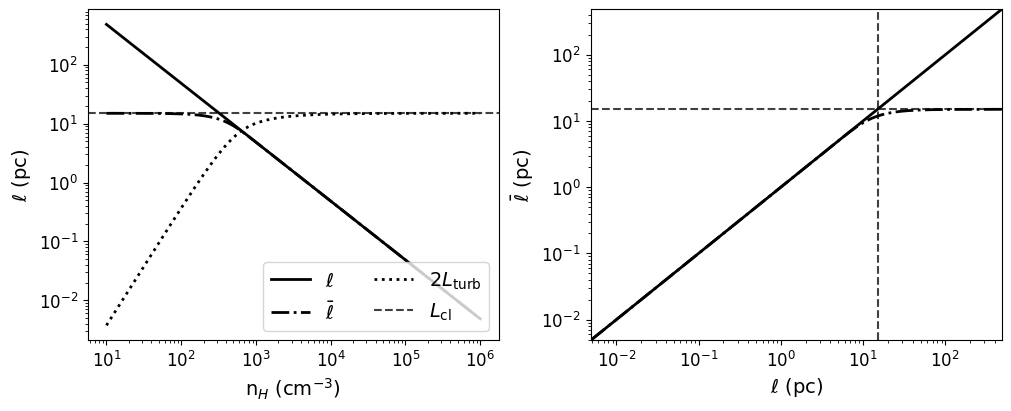

In [9]:
fig, (ax, ax2) = plt.subplots(ncols=2,nrows=1, figsize=(10,4), layout='constrained')
ax.loglog(n_arr, ell, 'k-', lw=2.0, label=r"$\ell$")
ax.loglog(n_arr, ell_eff, 'k-.', lw=2.0, label=r"$\bar{\ell}$")
ax.loglog(n_arr, 2.0*Lturb, 'k:', lw=2.0, label=r"$2L_{\rm turb}$")
ax.axhline(y = LclFid.value, color='k', alpha=0.75, lw=1.5, linestyle='--', label=r"$L_{\rm cl}$")
ax.legend(loc=4, ncols=2, fontsize=14)

ax.set_xlabel(r"n$_H$ (cm$^{-3}$)", fontsize=14)
ax.set_ylabel(r"$\ell$ (pc)", fontsize=14)
ax.tick_params(which='both', axis='both', labelsize=12)

ax2.loglog(ell, ell, 'k-', lw=2.0, label="1:1")
ax2.loglog(ell, ell_eff, 'k-.', lw=2.0, label=r"$\bar{\ell}$")
ax2.axhline(y = LclFid.value, color='k', alpha=0.75, lw=1.5, linestyle='--')
ax2.axvline(x = LclFid.value, color='k', alpha=0.75, lw=1.5, linestyle='--')

ax2.set_xlabel(r"$\ell$ (pc)", fontsize=14)
ax2.set_ylabel(r"$\bar{\ell}$ (pc)", fontsize=14)
ax2.tick_params(which='both', axis='both', labelsize=12)
ax2.set_ylim(ell.value.min(), ell.value.max())
ax2.set_xlim(ell.value.min(), ell.value.max())
plt.show()

In [10]:
Neff_fid = NHnh(n_arr, LclFid, csFid, navgFid, alphaVFid, sigma0Fid, betaFid)
Nturb_fl, NJ_fl, Neff_fid_fl = NHnh(n_arr, LclFid, csFid, navgFid, alphaVFid, sigma0Fid, betaFid, Nfloor = Nfloor, Nres = Nres, returnFull = True)

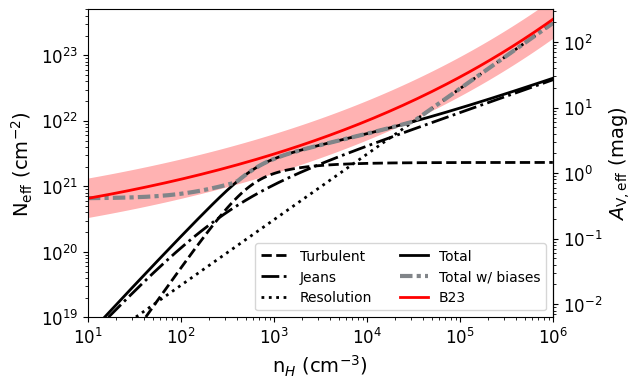

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

#ax.contour(xAvgc, yAvgc, Havg.T, levels=6, colors='k', linewidths=1.5)
ax.plot(n_arr, Nturb_fl, 'k--', lw=2.0, label="Turbulent")
ax.plot(n_arr, NJ_fl, 'k-.', lw=2.0, label="Jeans")
ax.plot(n_arr, Nres, 'k:', lw=2.0, label="Resolution")
ax.plot(n_arr, Neff_fid, 'k-', lw=2.0, label="Total")
ax.plot(n_arr, Neff_fid_fl, ls=(0, (3, 1, 1, 1)), color='#818589', lw=3.0, label="Total w/ biases")
ax.fill_between(n_arr.value, lowFit.value, highFit.value, facecolor='r', alpha=0.3)
ax.plot(n_arr, bisbasFitNcol, 'r-', lw=2.0, label="B23")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"n$_H$ (cm$^{-3}$)", fontsize=14)
ax.set_ylabel(r"N$_{\rm eff}$ (cm$^{-2}$)", fontsize=14)
ax.tick_params(which='both', axis='both', labelsize=12)

ax.legend(loc=4, fontsize=10, ncols=2)
ax.set_ylim(1E19, 5E23)
ax.set_xlim(n_arr[0].value, n_arr[-1].value)

ax2 = ax.secondary_yaxis("right", functions=(T_AV, T_N))
ax2.set_ylabel(r"$A_{\rm V, eff}$ (mag)", fontsize=14)
ax2.tick_params(which='both', axis='both', labelsize=12)

plt.show()

## Parameter variation

In [12]:
#6 parameters, so a 2x3 plot
Nmodels = 10
Lspace = np.linspace(1., 20., Nmodels)*u.pc
Tspace = np.linspace(10., 100., Nmodels)*u.K
n0Space = np.logspace(1, 3, Nmodels)*u.cm**-3
alphaSpace = np.linspace(0.5, 5, Nmodels)
sigma0Space = np.linspace(0.2, 5.0, Nmodels)*u.km/u.s
betaSpace = np.linspace(0.3, 0.7 , Nmodels)

csSpace = (np.sqrt(c.k_B*Tspace/(mup * c.m_p))).to(u.km/u.s)

In [13]:
# Do parameter space for L arr
edge_order = 1
Lresults = []
Lgrad = []
for Li in Lspace:
    Ni = NHnh(n_arr, Li, csFid, navgFid, alphaVFid, sigma0Fid, betaFid)
    Lresults.append(Ni)
    Lgrad.append(np.gradient(np.log10(Ni.value), ln_arr, edge_order=edge_order))

# Do parameter space results for T space:
Tresults = []
Tgrad = []
for csi in csSpace:
    Ni = NHnh(n_arr, LclFid, csi, navgFid, alphaVFid, sigma0Fid, betaFid)
    Tresults.append(Ni)
    Tgrad.append(np.gradient(np.log10(Ni.value), ln_arr, edge_order=edge_order))

# Parameter space results for n0 space:
n0results = []
n0grad = []
for navgi in n0Space:
    Ni = NHnh(n_arr, LclFid, csFid, navgi, alphaVFid, sigma0Fid, betaFid)
    n0results.append(Ni)
    n0grad.append(np.gradient(np.log10(Ni.value), ln_arr, edge_order=edge_order))

#Parameter space results for alpha space
alphaVresults = []
alphaVgrad = []
for alphaVi in alphaSpace:
    Ni = NHnh(n_arr, LclFid, csFid, navgFid, alphaVi, sigma0Fid, betaFid)
    alphaVresults.append(Ni)
    alphaVgrad.append(np.gradient(np.log10(Ni.value), ln_arr, edge_order=edge_order))

sigma0results = []
sigma0grad = []
for sigma0i in sigma0Space:
    Ni = NHnh(n_arr, LclFid, csFid, navgFid, alphaVFid, sigma0i, betaFid)
    sigma0results.append(Ni)
    sigma0grad.append(np.gradient(np.log10(Ni.value), ln_arr, edge_order=edge_order))

betaresults = []
betagrad = []
for betai in betaSpace:
    Ni = NHnh(n_arr, LclFid, csFid, navgFid, alphaVFid, sigma0Fid, betai)
    betaresults.append(Ni)
    betagrad.append(np.gradient(np.log10(Ni.value), ln_arr, edge_order=edge_order))

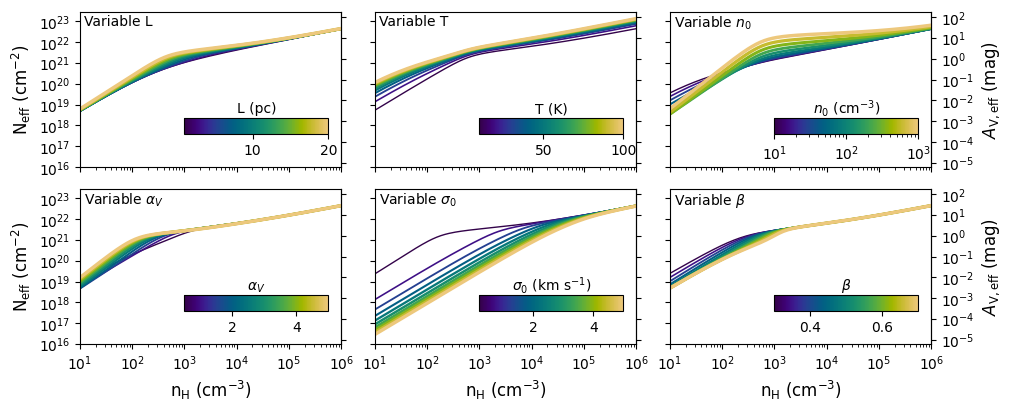

In [14]:
ncols = 3
nrows = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, layout='constrained', sharex=True, sharey=True, figsize=(10,4))
axs = axs.flatten()
linewidths = np.linspace(1.0,2.5,Nmodels)
linecolors = cmr.take_cmap_colors('cmr.rainforest', Nmodels, cmap_range=(0.15, 0.85), return_fmt='hex')
cmap = cmr.get_sub_cmap('cmr.rainforest', 0.15, 0.85)

mins = [Lspace[0].value, Tspace[0].value, n0Space[0].value, alphaSpace[0], sigma0Space[0].value, betaSpace[0]]
maxes = [Lspace[-1].value, Tspace[-1].value, n0Space[-1].value, alphaSpace[-1], sigma0Space[-1].value, betaSpace[-1]]

labels = ["Variable L", "Variable T", r"Variable $n_0$", r"Variable $\alpha_V$",
          r"Variable $\sigma_0$", r"Variable $\beta$"]
cbLabels = ["L (pc)", "T (K)", r"$n_0$ (cm$^{-3}$)", r"$\alpha_V$",
            r"$\sigma_0$ (km s$^{-1}$)", r"$\beta$"]

for i in range(Nmodels):
    axs[0].loglog(n_arr, Lresults[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[1].loglog(n_arr, Tresults[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[2].loglog(n_arr, n0results[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[3].loglog(n_arr, alphaVresults[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[4].loglog(n_arr, sigma0results[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[5].loglog(n_arr, betaresults[i], '-', lw=linewidths[i], color=linecolors[i])

for (i, axi) in enumerate(axs):
    axi.annotate(labels[i], ha='left', va='top', xycoords='axes fraction', 
                 xy=(0.015, 0.985), fontsize=10)
    axi.set_xlim(n_arr[0].value, n_arr[-1].value)
    axi.set_yticks([1E16, 1E17, 1E18, 1E19, 1E20, 1E21, 1E22, 1E23])
    
    axi_ins = axi.inset_axes([0.40, 0.215, 0.55, 0.1])
    if i != 2:
        cbi = fig.colorbar(mpl.cm.ScalarMappable(norm=colors.Normalize(mins[i], maxes[i]), cmap=cmap), cax=axi_ins, orientation='horizontal')
    else:
        cbi = fig.colorbar(mpl.cm.ScalarMappable(norm=colors.LogNorm(mins[i], maxes[i]), cmap=cmap), cax=axi_ins, orientation='horizontal')
    cbi.set_label(cbLabels[i], fontsize=10)
    cbi.ax.xaxis.set_label_position('top')

    
    ax2i = axi.secondary_yaxis("right", functions=(T_AV, T_N))
    ax2i.set_yticks([1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10, 100])
    if i%ncols == ncols-1:
        ax2i.set_ylabel(r"$A_{\rm V, eff}$ (mag)", fontsize=12)
    else:
        ax2i.set_yticklabels("")

for (i,axi) in enumerate(axs):
    if i % ncols == 0:
        axi.set_ylabel(r"N$_{\rm eff}$ (cm$^{-2}$)", fontsize=12)
    if i // ncols == nrows-1:
        axi.set_xlabel(r"n$_{\rm H}$ (cm$^{-3}$)", fontsize=12)

plt.show()

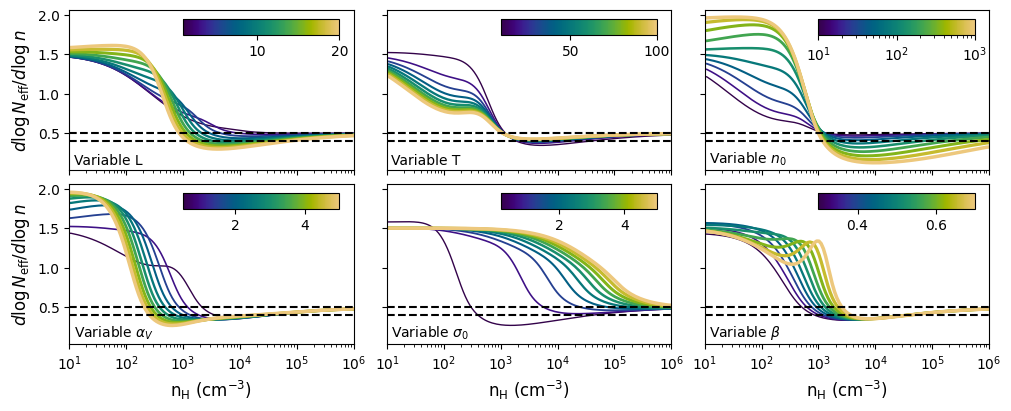

In [15]:
ncols = 3
nrows = 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, layout='constrained', sharex=True, sharey=True, figsize=(10,4))
axs = axs.flatten()
linewidths = np.linspace(1.0,2.5,Nmodels)
linecolors = cmr.take_cmap_colors('cmr.rainforest', Nmodels, cmap_range=(0.15, 0.85), return_fmt='hex')
cmap = cmr.get_sub_cmap('cmr.rainforest', 0.15, 0.85)

mins = [Lspace[0].value, Tspace[0].value, n0Space[0].value, alphaSpace[0], sigma0Space[0].value, betaSpace[0]]
maxes = [Lspace[-1].value, Tspace[-1].value, n0Space[-1].value, alphaSpace[-1], sigma0Space[-1].value, betaSpace[-1]]

labels = ["Variable L", "Variable T", r"Variable $n_0$", r"Variable $\alpha_V$",
          r"Variable $\sigma_0$", r"Variable $\beta$"]
cbLabels = ["L (pc)", "T (K)", r"$n_0$ (cm$^{-3}$)", r"$\alpha_V$",
            r"$\sigma_0$ (km s$^{-1}$)", r"$\beta$"]

for i in range(Nmodels):
    axs[0].plot(n_arr, Lgrad[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[1].plot(n_arr, Tgrad[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[2].plot(n_arr, n0grad[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[3].plot(n_arr, alphaVgrad[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[4].plot(n_arr, sigma0grad[i], '-', lw=linewidths[i], color=linecolors[i])
    axs[5].plot(n_arr, betagrad[i], '-', lw=linewidths[i], color=linecolors[i])

for (i, axi) in enumerate(axs.flatten()):
    axi.set_yscale('linear')
    axi.set_xscale('log')
    axi.annotate(labels[i], ha='left', va='bottom', xycoords='axes fraction', 
                 xy=(0.015, 0.015), fontsize=10)
    axi.set_xlim(n_arr[0].value, n_arr[-1].value)
    
    axi_ins = axi.inset_axes([0.4, 0.845, 0.55, 0.1])
    if i != 2:
        cbi = fig.colorbar(mpl.cm.ScalarMappable(norm=colors.Normalize(mins[i], maxes[i]), cmap=cmap), cax=axi_ins, orientation='horizontal')
    else:
        cbi = fig.colorbar(mpl.cm.ScalarMappable(norm=colors.LogNorm(mins[i], maxes[i]), cmap=cmap), cax=axi_ins, orientation='horizontal')
    #cbi.set_label(cbLabels[i], fontsize=10)
    cbi.ax.xaxis.set_label_position('top')
    
    axi.axhline(y=0.4, color='k', lw=1.5, linestyle='--')
    axi.axhline(y=0.5, color='k', lw=1.5, linestyle='--')
    #axi.axhline(y=1.0, color='k', lw=1.5, linestyle='--')


for (i,axi) in enumerate(axs):
    if i % ncols == 0:
        axi.set_ylabel(r"$d\log N_{\rm eff}/d\log n$", fontsize=12)
    if i // ncols == nrows-1:
        axi.set_xlabel(r"n$_{\rm H}$ (cm$^{-3}$)", fontsize=12)

plt.show()

## n-T Grid

In [16]:
T_arr = np.linspace(10, 100, 128)*u.K
n_grid, T_grid = np.meshgrid(n_arr, T_arr)
Neff_grid = np.zeros_like(n_grid.value) * u.cm**(-2)

In [17]:
for (i, T) in enumerate(T_arr):
    csi = (np.sqrt(c.k_B*T/(mup * c.m_p))).to(u.km/u.s)
    Neff_i = NHnh(n_arr, LclFid, csi, navgFid, alphaVFid, sigma0Fid, betaFid)
    Neff_grid[i,:] = Neff_i.copy()
AV_grid = Neff_grid * AV_fac

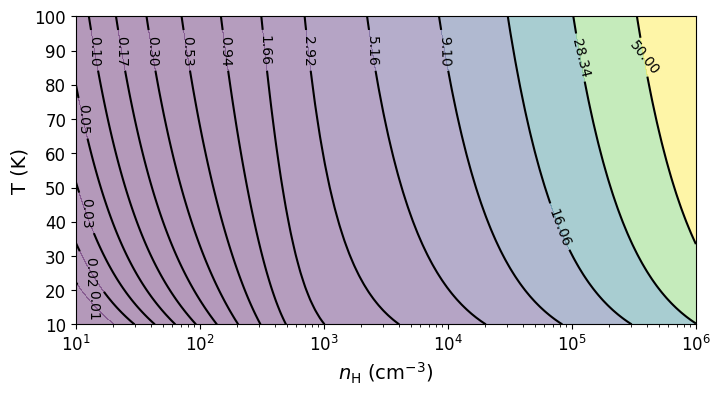

In [18]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
#levels = np.linspace(19,23, 16)
levels = np.logspace(-2,np.log10(50),16)
cf1 = ax.contourf(n_grid, T_grid, AV_grid.value, levels=levels, extend='both', alpha=0.4)
c1 = ax.contour(n_grid, T_grid, AV_grid.value, levels=levels, colors='k')
ax.clabel(c1, fmt = "%.2f")
ax.set_xlabel(r"$n_{\rm H}$ (cm$^{-3}$)", fontsize=14)
ax.set_ylabel("T (K)", fontsize=14)
ax.set_xscale('log')
ax.tick_params(which='both', axis='both', labelsize=12)
plt.show()